<a href="https://colab.research.google.com/github/bt22dr/PRML/blob/master/PRML_chapter_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. Mixture Models and EM

## 9.1. K-means Clustering

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-rc1

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
import copy
import math
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
from google.colab import files
files.upload()

In [0]:
# Next, install the Kaggle API client.
!pip install -U kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
# !kaggle datasets list
!kaggle datasets list --search old-faithful

# Download dataset
!kaggle datasets download -d janithwanni/old-faithful

# Unzip the dataset file
!unzip old-faithful.zip

In [45]:
URL = 'faithful.csv'
dataframe = pd.read_csv(URL)
dataframe = dataframe[['eruptions', 'waiting']]
dataframe.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [46]:
standardScaler = StandardScaler()
standardScaler.fit(dataframe)
faithful_data = standardScaler.transform(dataframe)
print(faithful_data[:10])

[[ 0.09849886  0.59712344]
 [-1.48145856 -1.24518118]
 [-0.13586149  0.22866251]
 [-1.05750332 -0.6556437 ]
 [ 0.91744345  1.03927655]
 [-0.53085085 -1.171489  ]
 [ 1.06402839  1.2603531 ]
 [ 0.09849886  1.03927655]
 [-1.34979544 -1.46625773]
 [ 0.75681445  1.03927655]]


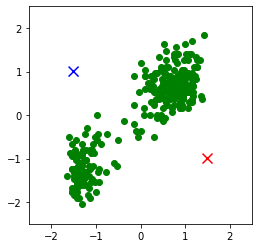

In [47]:
mu = tf.constant([[-1.5, 1],[1.5,-1]], dtype=tf.float32)

plt.figure(figsize=(4,4)); plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
plt.plot(faithful_data[:,0], faithful_data[:,1], 'go')
plt.scatter(mu[:,0], mu[:,1], c=['b', 'r'], s=100, marker="x")

In [0]:
class KMeans():
  def __init__(self, X, K):
    self.N = len(X)
    self.D = len(X[0])
    self.K = K
    self.X = X
    self.R = tf.ones_like(X)
    self.mu = tf.constant([[-1.5, 1],[1.5,-1]], dtype=tf.float32)
    self.loss = []

  def cost_function(self):
    R = self.R
    X = self.X
    mu = self.mu

    J = 0
    for n, r_n in enumerate(R):
      for k, r_nk in enumerate(r_n):
        J = J + r_nk.numpy() * tf.math.square(tf.norm(X[n] - mu[k])) # (eq. 9.1)
    return J.numpy()

  def plot_current_state(self):
    K = self.K
    X = self.X
    mu = self.mu

    cols = ['b', 'r', 'y']
    plt.figure(figsize=(4,4)); plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
    for k in range(K):
      plt.scatter(X[self.cluster_k_idx[k],0], 
              X[self.cluster_k_idx[k],1], c=cols[k], s=30, marker="o")
    plt.scatter(mu[:,0], mu[:,1], c='w', s=400, marker="X")
    plt.scatter(mu[:,0], mu[:,1], c=cols[:K], s=100, marker="x")

  def train_one_step(self):
    X = self.X
    K = self.K
    N = self.N
    mu = self.mu

    def step_E(): # update r_nk
      R = []
      for n in range(N):
        k = tf.argmin(tf.math.square(tf.norm(X[n] - mu, axis=-1)))
        r_n = tf.one_hot(k, depth=K, dtype=tf.int32) # (eq. 9.2)
        R.append(r_n)
      self.R = tf.stack(R)

      self.cluster_k_idx = []
      for k in range(K):
        self.cluster_k_idx.append(tf.squeeze(tf.where(self.R[:,k])))

    def step_M(): # update mu_k
      mu = []
      for k in range(K):
        m = tf.reduce_mean(X[self.cluster_k_idx[k]], axis=0) # (eq. 9.4)
        mu.append(m)
      self.mu = tf.stack(mu)

    step_E()
    self.plot_current_state()
    self.loss.append(self.cost_function())

    step_M()
    self.plot_current_state()
    self.loss.append(self.cost_function())

  def train(self, iter=100):
    for i in range(iter):
      J = self.cost_function()
      print("Iteration {}: cost {}".format(i, J))

      self.train_one_step()
      if tf.math.abs(self.loss[-1] - self.loss[-2]) < 1e-1:
        break

Iteration 0: cost 2855.99951171875
Iteration 1: cost 325.2789988495719
Iteration 2: cost 80.96792556114691
Iteration 3: cost 79.63566081947319


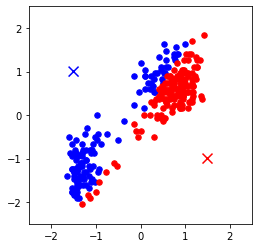

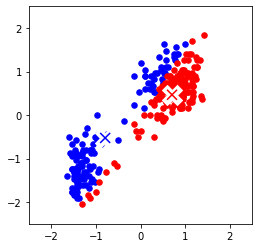

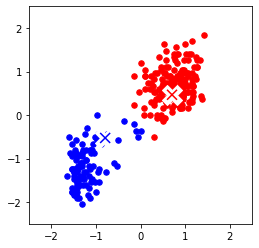

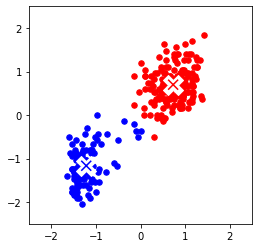

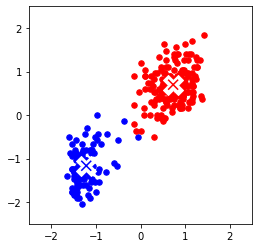

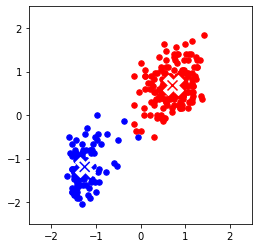

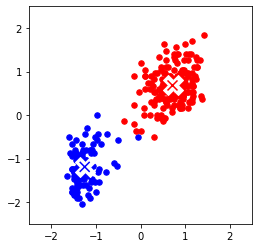

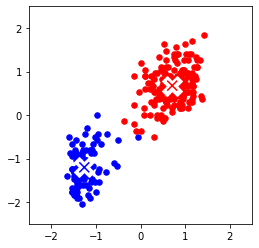

In [49]:
model = KMeans(faithful_data, 2)
model.train()

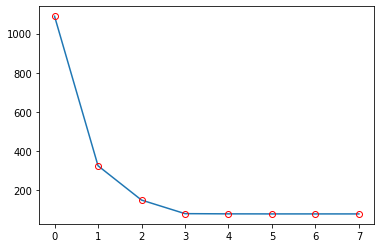

In [50]:
plt.plot(model.loss)
plt.plot(model.loss, 'ro', fillstyle='none')

## 9.2. Mixtures of Gaussians

In [0]:
class MultivariateGaussian:
  def __init__(self, mu=None, cov=None):
    self.mu = mu
    self.cov = cov
    if mu is not None and cov is not None:
      self.mu = tf.reshape(tf.cast(mu, tf.float64), shape=[-1, 1])
      self.D  = self.mu.shape[0]
      self.cov = tf.cast(cov, tf.float64)

  def mean(self):
    return tf.squeeze(self.mu)
  
  def covariance(self):
    return self.cov

  def pdf(self, x):
    mu = self.mu
    cov = self.cov
    
    if tf.rank(x) == 1:
      x = tf.expand_dims(x, 0)
    x = tf.transpose(tf.cast(x, tf.float64))
    d = tf.math.subtract(x, mu)
    precision_mat = tf.linalg.inv(cov)
    return tf.squeeze(
      tf.linalg.diag_part(
        tf.math.exp(-0.5 * tf.matmul(
            tf.matmul(tf.transpose(d), precision_mat), d))
        / tf.math.sqrt(tf.linalg.det(cov))
        / tf.math.pow(tf.cast(2.0, tf.float64) * math.pi, 0.5 * self.D)))

  def mle(self, D):
    N = len(D)
    sample_mean = tf.reduce_mean(D, axis=0) # (eq. 2.122)
    self.mu = tf.reshape(sample_mean, shape=[-1, 1])
    D = tf.transpose(D)
    d = tf.subtract(D, self.mu)
    self.cov = (1/(N-1) * tf.matmul(d, tf.transpose(d))) # (eq. 2.125)

    return self.mean(), self.covariance()

  # TODO: np 제거
  def sample(self, sample_size):
    import numpy as np
    mu = tf.squeeze(self.mu)
    cov = self.cov
    return np.random.multivariate_normal(mu, cov, sample_size)

In [52]:
N = 500
K = 3
pi = [0.5, 0.3, 0.2]
mu = tf.constant([[0.2, 0.4],[0.5, 0.5],[0.8, 0.6]])
cov = tf.constant([[[1.0,  0.8], [ 0.8, 1.0]],
                   [[1.0, -0.8], [-0.8, 1.0]],
                   [[1.0,  0.8], [ 0.8, 1.0]]]) * 0.015
norm_dist = MultivariateGaussian(mu[0], cov[0])
samples_r = norm_dist.sample(int(N * pi[0]))
norm_dist = MultivariateGaussian(mu[1], cov[1])
samples_g = norm_dist.sample(int(N * pi[1]))
norm_dist = MultivariateGaussian(mu[2], cov[2])
samples_b = norm_dist.sample(int(N * pi[2]))

samples = tf.concat([samples_r, samples_g, samples_b], axis=0)
samples.shape

TensorShape([500, 2])

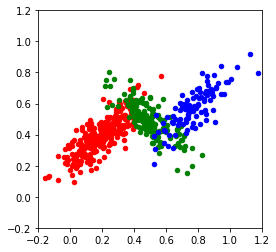

In [53]:
plt.figure(figsize=(4,4))
plt.xlim(-0.2, 1.2);plt.ylim(-0.2, 1.2);
plt.scatter(samples_r[:,0], samples_r[:,1], c='r', s=20, marker="o")
plt.scatter(samples_g[:,0], samples_g[:,1], c='g', s=20, marker="o")
plt.scatter(samples_b[:,0], samples_b[:,1], c='b', s=20, marker="o")

In [54]:
def responsibilities(X, mu, cov, pi, K):
  responsibilities = []
  for x in X:
    pxz = []
    for k in range(K):
      gauss = MultivariateGaussian(mu[k], cov[k])
      pxz.append(tf.cast(pi[k], tf.float64) * gauss.pdf(x))
    px = tf.reduce_sum(pxz) # (eq. 9.12)
    responsibility = pxz / px  # (eq. 9.13)
    responsibilities.append(responsibility)
  responsibilities = tf.stack(responsibilities)
  return responsibilities

responsibility = responsibilities(samples, mu, cov, pi, K)
print(responsibility.shape)

(500, 3)


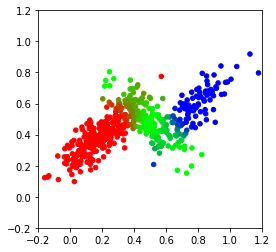

In [55]:
plt.figure(figsize=(4,4))
plt.xlim(-0.2, 1.2);plt.ylim(-0.2, 1.2);
plt.scatter(samples[:,0], samples[:,1], c=responsibility, s=20, marker="o")

In [0]:
class Multinoulli:
  def __init__(self, mu=None):
    if mu is not None:
      assert self.check_parameter(mu), "mu >= 0 & sum(mu) == 1"
    self.mu = tf.reshape(mu, (-1,1))

  def check_support(self, x):
    if tf.rank(x) == 0:
      return x in range(1, len(self.mu)+1)
    else:
      return all([e.numpy() in [0, 1] for e in x]) and tf.reduce_sum(x) == 1

  def check_parameter(self, mu):
    return all([e.numpy() >= 0 for e in mu]) and tf.reduce_sum(mu) == 1 # (eq. 2.27)
  
  def mean(self):
    return tf.squeeze(self.mu) # (eq. 2.28)
  
  def pmf(self, x):
    assert self.check_support(x), "x in {1, ..., len(mu)} or one_hot(x)"
    mu = self.mu
    if tf.rank(x) == 0:
      x = tf.one_hot(x-1, len(mu)) # (eq. 2.25)
    x = tf.reshape(tf.cast(x, tf.float32), [-1,1])
    return tf.reduce_prod(tf.math.pow(mu, x))

  def likelihood(self, D, mu):
    D = tf.cast(D, tf.float32)
    m_k = tf.reduce_sum(D, axis=0)
    return tf.reduce_prod(tf.math.pow(mu, m_k)) # (eq. 2.29)

  def mle(self, D):
    D = tf.cast(D, tf.float32)
    mu = tf.reduce_mean(D, axis=0) # (eq. 2.33)
    self.mu = tf.reshape(mu, [-1, 1])
    return mu

In [57]:
mu = tf.constant(pi)
z = tf.constant([1, 0, 0])
pz = Multinoulli(mu)
print(pz.pmf(z))
print(pz.mean())

tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor([0.5 0.3 0.2], shape=(3,), dtype=float32)


### 9.2.2 EM for Gaussian mixtures

In [0]:
# 참고: http://pypr.sourceforge.net/mog.html

def gauss_ellipse_2d(centroid, ccov, sdwidth=1, points=100):
  import numpy as np
  mean = np.c_[centroid]
  tt = np.c_[np.linspace(0, 2*np.pi, points)]
  x = np.cos(tt); y=np.sin(tt);
  ap = np.concatenate((x,y), axis=1).T
  d, v = np.linalg.eig(ccov);
  d = np.diag(d)
  d = sdwidth * np.sqrt(d); # convert variance to sdwidth*sd
  bp = np.dot(v, np.dot(d, ap)) + np.tile(mean, (1, ap.shape[1])) 
  return bp[0,:], bp[1,:]

In [0]:
N = len(faithful_data)
K = 2

mu  = tf.constant([[-1.5, 1], [1.5,-1]], dtype=tf.float64)
cov = tf.constant([[[1.0, 0.0], [0.0, 1.0]],
                   [[1.0, 0.0], [0.0, 1.0]]])
pi = tf.ones([K,], tf.float64)/K

In [60]:
def log_likelihood(X, pi, mu, cov):
  log_likelihood = 0.0
  for n, x_n in enumerate(X):
    p_xn = 0.0
    for k in range(K):
      gauss = MultivariateGaussian(mu[k], cov[k])
      p_xn = p_xn + (tf.cast(pi[k], tf.float64) * gauss.pdf(x_n)) # eq. 9.14
    log_p_xn = tf.math.log(p_xn)
    log_likelihood = log_likelihood + log_p_xn
  return log_likelihood

log_likelihood(faithful_data, pi, mu, cov)

<tf.Tensor: id=28204425, shape=(), dtype=float64, numpy=-1150.201994442709>

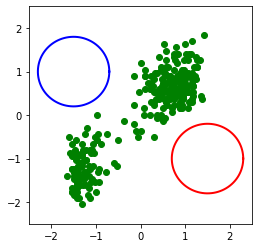

In [61]:
plt.figure(figsize=(4,4)); plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
plt.plot(faithful_data[:,0], faithful_data[:,1], 'go')
for i in range(K):
  x1, x2 = gauss_ellipse_2d(mu[i], cov[i], 0.8)
  plt.plot(x1, x2, 'w', linewidth=6)
  plt.plot(x1, x2, ['b', 'r'][i], linewidth=2)

In [0]:
def responsibilities(X, mu, cov, pi, K):
  responsibilities = []
  for x in X:
    pxz = []
    for k in range(K):
      gauss = MultivariateGaussian(mu[k], cov[k])
      pxz.append(tf.cast(pi[k], tf.float64) * gauss.pdf(x))
    px = tf.reduce_sum(pxz) # (eq. 9.12)
    responsibility = pxz / px  # (eq. 9.13)
    responsibilities.append(responsibility)
  responsibilities = tf.stack(responsibilities)
  return responsibilities

responsibility = responsibilities(faithful_data, mu, cov, pi, K)

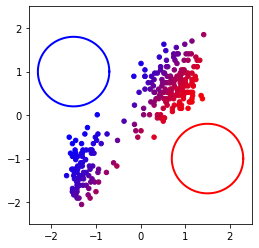

In [63]:
colors = tf.stack([responsibility[:,1], tf.zeros_like(responsibility[:,0]), responsibility[:,0]])
colors = tf.transpose(colors)

plt.figure(figsize=(4,4)); plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
plt.scatter(faithful_data[:,0], faithful_data[:,1], c=colors, s=20, marker="o")

for i in range(K):
  x1, x2 = gauss_ellipse_2d(mu[i], cov[i], 0.8)
  plt.plot(x1, x2, 'w', linewidth=6)
  plt.plot(x1, x2, ['b', 'r'][i], linewidth=2)

In [64]:
def update_mu(X, responsibility, K):
  mu = []
  for n, xn in enumerate(X):
    mu_k = []
    for k in range(K):
      mu_k.append(responsibility[n][k] * xn)
    mu.append(mu_k)
  mu = tf.reduce_sum(tf.stack(mu), axis=0)

  Nk = tf.reduce_sum(responsibility, axis=0) # (eq. 9.18)
  mu = mu/Nk # eq. 9.17
  return mu

mu = update_mu(faithful_data, responsibility, K)
print(mu)

tf.Tensor(
[[-0.46432397 -0.27924414]
 [ 0.46432397  0.27924414]], shape=(2, 2), dtype=float64)


In [65]:
def update_cov(X, mu, responsibility, K):
  # (eq. 9.19)
  Nk = tf.reduce_sum(responsibility, axis=0) # (eq. 9.18)
  cov = []
  for k in range(K):
    cov_k = []
    for n, xn in enumerate(faithful_data):
      res = tf.reshape(xn - mu[k], [-1,1])
      gamma = responsibility[n][k]
      cov_k.append(gamma * tf.matmul(res,  tf.transpose(res)))
    cov_k = tf.stack(cov_k)
    cov_k = tf.reduce_sum(cov_k, axis=0)
    cov_k = cov_k / Nk[k]
    cov.append(cov_k)
  cov = tf.stack(cov)
  return cov

cov = update_cov(faithful_data, mu, responsibility, K)
print(cov)

tf.Tensor(
[[[0.93594169 0.94032099]
  [0.94032099 1.12196324]]

 [[0.64124473 0.60441458]
  [0.60441458 0.72271471]]], shape=(2, 2, 2), dtype=float64)


In [66]:
def update_pi(N):
  Nk = tf.reduce_sum(responsibility, axis=0) # (eq. 9.18)
  pi = Nk / N
  return pi

pi = update_pi(N)
print(pi)

tf.Tensor([0.49637886 0.50362114], shape=(2,), dtype=float64)


In [67]:
log_likelihood(faithful_data, pi, mu, cov)

<tf.Tensor: id=28275500, shape=(), dtype=float64, numpy=-536.8220954114436>

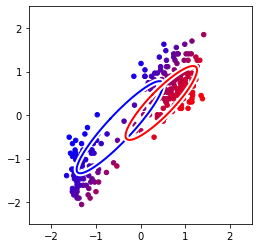

In [68]:
colors = tf.stack([responsibility[:,1], tf.zeros_like(responsibility[:,0]), responsibility[:,0]])
colors = tf.transpose(colors)

plt.figure(figsize=(4,4)); plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
plt.scatter(faithful_data[:,0], faithful_data[:,1], c=colors, s=20, marker="o")

for i in range(K):
  x1, x2 = gauss_ellipse_2d(mu[i], cov[i])
  plt.plot(x1, x2, 'w', linewidth=6)
  plt.plot(x1, x2, ['b', 'r'][i], linewidth=2)

L=0, log-likelihood: -527.9590453948553


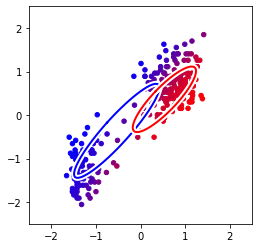

L=1, log-likelihood: -504.03317746873904


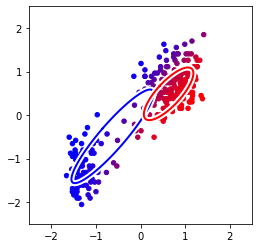

L=2, log-likelihood: -461.4776604603026


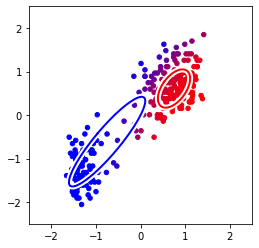

L=3, log-likelihood: -454.55706716777905


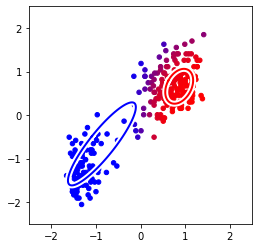

L=4, log-likelihood: -461.9589773879595


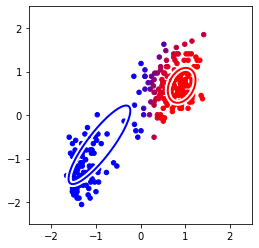

L=5, log-likelihood: -470.7750490843624


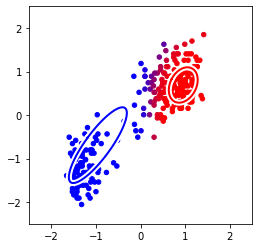

L=6, log-likelihood: -480.45021965281893


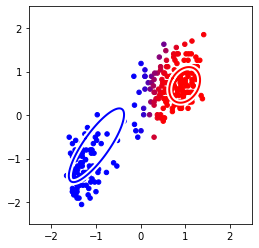

L=7, log-likelihood: -491.5161197966037


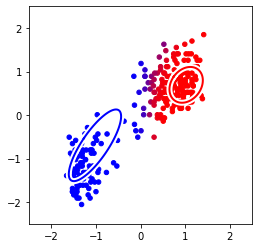

L=8, log-likelihood: -504.43821254573135


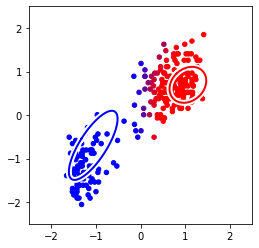

L=9, log-likelihood: -518.8685489550052


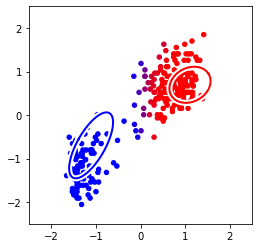

L=10, log-likelihood: -532.7066228125257


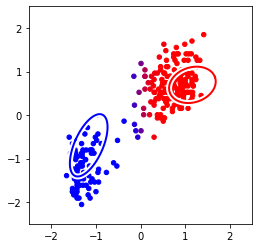

L=11, log-likelihood: -542.5031616343188


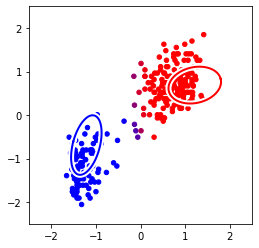

L=12, log-likelihood: -548.3759170963217


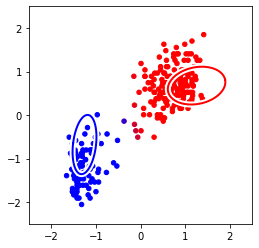

L=13, log-likelihood: -552.3771877020657


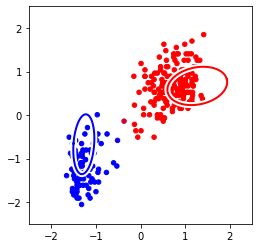

L=14, log-likelihood: -553.6576092082463


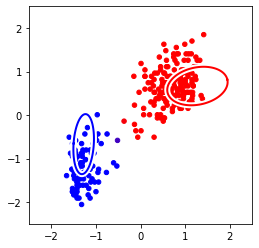

L=15, log-likelihood: -554.0197414435585


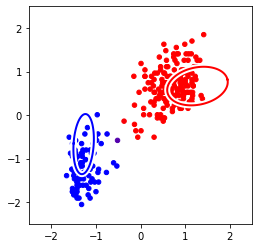

L=16, log-likelihood: -554.1250524635753


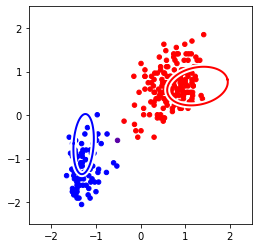

L=17, log-likelihood: -554.1560898735344


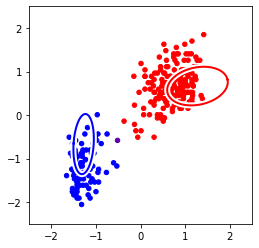

L=18, log-likelihood: -554.1652758015628


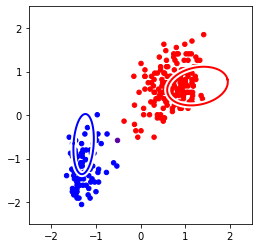

L=19, log-likelihood: -554.1679979121752


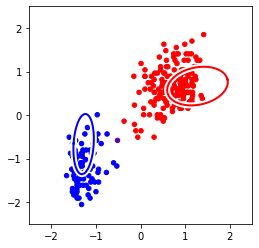

In [69]:
for i in range(20):
  responsibility = responsibilities(faithful_data, mu, cov, pi, K)
  
  mu = update_mu(faithful_data, responsibility, K)
  cov = update_cov(faithful_data, mu, responsibility, K)
  pi = update_pi(N)
  # print(mu)
  # print(cov)
  # print(pi)

  print("L={}, log-likelihood: {}".format(i, log_likelihood(faithful_data, pi, mu, cov)))

  colors = tf.stack([responsibility[:,1], tf.zeros_like(responsibility[:,0]), responsibility[:,0]])
  colors = tf.transpose(colors)

  plt.figure(figsize=(4,4)); plt.xlim(-2.5,2.5); plt.ylim(-2.5,2.5)
  plt.scatter(faithful_data[:,0], faithful_data[:,1], c=colors, s=20, marker="o")

  for i in range(K):
    x1, x2 = gauss_ellipse_2d(mu[i], cov[i])
    plt.plot(x1, x2, 'w', linewidth=6)
    plt.plot(x1, x2, ['b', 'r'][i], linewidth=2)
  plt.show()

### 9.3.3 Mixtures of Bernoulli distributions

(60000, 28, 28)


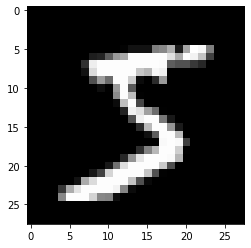

In [70]:
from tensorflow import keras

mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
plt.imshow(train_images[0], cmap=plt.get_cmap("gray"))

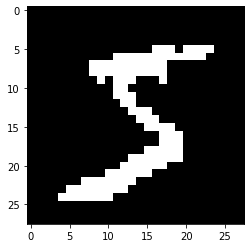

In [71]:
dataset = tf.where(train_images > 125, 1, 0)
plt.imshow(dataset[0], cmap=plt.get_cmap("gray"))

In [0]:
class Bernoulli:
  def __init__(self, mu=None):
    if mu is not None:
      mu = tf.cast(mu, tf.float32)
      assert self.check_parameter(mu), "0 <= mu <= 1, (scalar or column vector)"
    self.mu = mu

  def check_support(self, x):
    if tf.rank(x) == 0:
      return x in [0, 1]
    else:
      return all([e in [0, 1] for e in x.numpy().flatten()])

  def check_parameter(self, mu):
    if tf.rank(mu) == 0:
      return 0 <= mu <= 1
    elif tf.rank(mu) == 2:
      return all(0 <= mu) and all(mu <= 1)
    else:
      return False
  
  def mean(self):
    return self.mu # (eq. 2.3)
  
  def variance(self):
    mu = self.mu
    return mu * (1. - mu) # (eq. 2.4)

  def pmf(self, x):
    mu = self.mu
    x = tf.cast(x, tf.float32)
    assert self.check_support(x), "x in {0, 1}"
    return tf.math.pow(mu, x) * tf.math.pow((1. - mu), (1 - x)) # (eq. 2.2)

  def likelihood(self, D, mu):
    D = tf.cast(D, tf.float32)
    pow = tf.math.pow
    subtract = tf.math.subtract
    return tf.reduce_prod(
        pow(mu, D) * pow(subtract(1., mu), (1. - D)), 
        axis=-1, keepdims=True) # (eq. 2.5)

  def log_likelihood(self, D, mu):
    D = tf.cast(D, tf.float32)
    return tf.reduce_sum(
        D * tf.math.log(mu) + (1. - D) * tf.math.log(1. - mu)) # (eq. 2.6)
    
  def mle(self, D):
    D = tf.cast(D, tf.float32)
    mu = tf.reduce_mean(D, axis=-1, keepdims=True) # (eq. 2.7)
    if tf.rank(self.mu) == 0:
      mu = tf.squeeze(mu)
    assert mu.shape == self.mu.shape, "{} vs {}".format(mu.shape, self.mu.shape)
    self.mu = mu
    return self.mu

In [73]:
mu = tf.constant([0.1, 0.5, 0.9], shape=[3,1])
my_bern = Bernoulli(mu)

print("mean", my_bern.mean())
print("var", my_bern.variance())

print("================== my implementation ==================")
print(my_bern.pmf(0))
print(my_bern.pmf([0, 1]))
print(my_bern.pmf(tf.constant([0,1,1], shape=[3,1])))
print(my_bern.pmf(tf.constant([[0,1],[0,1],[0,1]], shape=[3,2])))

print("================== TF implementation ==================")
tf_bern = tfp.distributions.Bernoulli(probs=tf.constant([0.1, 0.5, 0.9], shape=[3,1]))
print(tf_bern.prob(0))
print(tf_bern.prob([0, 1]))
print(tf_bern.prob(tf.constant([0,1,1], shape=[3,1])))
print(tf_bern.prob(tf.constant([[0,1],[0,1],[0,1]], shape=[3,2])))

print("================== etc. ==================")
D = tf.constant([[1,1,1,1],[1,1,0,0],[0,0,0,0]])
print(my_bern.mle(D))
print(my_bern.likelihood(D, tf.constant([0.1, 0.5, 0.9], shape=[3,1])))

mean tf.Tensor(
[[0.1]
 [0.5]
 [0.9]], shape=(3, 1), dtype=float32)
var tf.Tensor(
[[0.09      ]
 [0.25      ]
 [0.09000002]], shape=(3, 1), dtype=float32)
================== my implementation ==================
tf.Tensor(
[[0.9       ]
 [0.5       ]
 [0.10000002]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.9        0.1       ]
 [0.5        0.5       ]
 [0.10000002 0.9       ]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[0.9]
 [0.5]
 [0.9]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.9        0.1       ]
 [0.5        0.5       ]
 [0.10000002 0.9       ]], shape=(3, 2), dtype=float32)
================== TF implementation ==================
tf.Tensor(
[[0.90000004]
 [0.5       ]
 [0.10000002]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.90000004 0.09999999]
 [0.5        0.5       ]
 [0.10000002 0.9       ]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[0.90000004]
 [0.5       ]
 [0.9       ]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.90000004 0.09999999]
 [0.5        0.5       ]
 [0.1

In [74]:
my_bern = Bernoulli(0.1)
print(my_bern.pmf(0), my_bern.pmf(1))
print(tf.math.log(my_bern.pmf([0, 1])))

tf_bern = tfp.distributions.Bernoulli(probs=0.1)
print(tf_bern.prob(0), tf_bern.prob(1))
print(tf_bern.log_prob([0, 1]))

D = [1,1,0,0]
print(my_bern.mle(D))

D = [1]
print(my_bern.likelihood(D, 0.0), my_bern.likelihood(D, 1.0))

D = [1,1,0]
print(my_bern.likelihood(D, 0.1), my_bern.likelihood(D, 0.9))

tf.Tensor(0.9, shape=(), dtype=float32) tf.Tensor(0.1, shape=(), dtype=float32)
tf.Tensor([-0.10536055 -2.3025851 ], shape=(2,), dtype=float32)
tf.Tensor(0.90000004, shape=(), dtype=float32) tf.Tensor(0.099999994, shape=(), dtype=float32)
tf.Tensor([-0.10536051 -2.3025851 ], shape=(2,), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32) tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([0.009], shape=(1,), dtype=float32) tf.Tensor([0.08100002], shape=(1,), dtype=float32)


In [75]:
D = 28*28
K = 3
N = 600
pi = tf.ones([K,], tf.float64)/K
mu = tf.random_uniform_initializer(0.25, 0.75)((K, D))
mu = mu / tf.reduce_sum(mu, axis=0)
print(mu)

tf.Tensor(
[[0.33342052 0.33034554 0.2764775  ... 0.38557893 0.4234283  0.33232933]
 [0.35328406 0.34810817 0.44281346 ... 0.340444   0.28687444 0.326651  ]
 [0.3132955  0.32154632 0.28070906 ... 0.27397707 0.28969726 0.34101966]], shape=(3, 784), dtype=float32)


In [76]:
digit_2 = train_images[train_labels == 2][:200]
digit_3 = train_images[train_labels == 3][:200]
digit_4 = train_images[train_labels == 4][:200]
digit_data = tf.concat([digit_2, digit_3, digit_4], axis=0)
digit_data = tf.reshape(digit_data, (N, -1))
digit_data = tf.where(digit_data > 125, 1, 0)
print(digit_data.shape)

(600, 784)


In [77]:
def responsibilities(X, mu, pi, K):
  responsibilities = []
  for x in X:
    x_n = tf.reshape(x, [-1,1])
    pxz = []
    for k in range(K):
      bern = Bernoulli(tf.reshape(mu[k], (-1,1)))
      p_xn_given_muk = tf.reduce_sum(tf.math.log(bern.pmf(x_n)))
      pxz.append(pi[k] * p_xn_given_muk.numpy())
    px = tf.reduce_sum(pxz) # (eq. )
    responsibility = pxz / px  # (eq. )
    responsibilities.append(responsibility)
  responsibilities = tf.stack(responsibilities)
  return responsibilities

responsibility = responsibilities(digit_data, mu, pi, K)
print(responsibility.shape)

(600, 3)


In [78]:
Nk = tf.reduce_sum(responsibility, axis=0)
print(Nk)

tf.Tensor([198.31378055 202.51273732 199.17348212], shape=(3,), dtype=float64)


In [0]:
mu = []
for k in range(K):
  tmp = []
  for n, x_n in enumerate(digit_data):
    tmp.append(responsibility[n][k] * tf.cast(x_n, tf.float64))
  tmp = tf.stack(tmp)
  mu.append(tf.reduce_sum(tmp, axis=0) / Nk[k])
mu = tf.stack(mu)

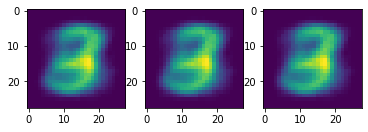

In [80]:
plt.subplot(1, 3, 1)
plt.imshow(tf.reshape(mu[0], (28,28)))
plt.subplot(1, 3, 2)
plt.imshow(tf.reshape(mu[1], (28,28)))
plt.subplot(1, 3, 3)
plt.imshow(tf.reshape(mu[2], (28,28)))

In [81]:
pi = Nk / N
print(pi)

tf.Tensor([0.33052297 0.33752123 0.3319558 ], shape=(3,), dtype=float64)


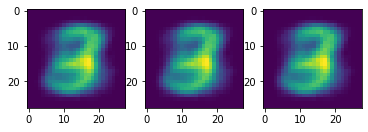

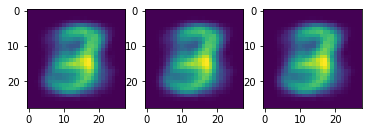

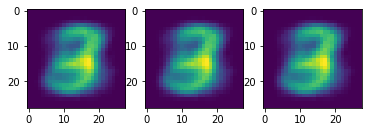

In [82]:
for i in range(3):
  responsibility = responsibilities(digit_data, mu, pi, K)

  Nk = tf.reduce_sum(responsibility, axis=0)
  
  mu = []
  for k in range(K):
    tmp = []
    for n, x_n in enumerate(digit_data):
      tmp.append(responsibility[n][k] * tf.cast(x_n, tf.float64))
    tmp = tf.stack(tmp)
    mu.append(tf.reduce_sum(tmp, axis=0) / Nk[k])
  mu = tf.stack(mu)

  pi = Nk / N

  plt.subplot(1, 3, 1)
  plt.imshow(tf.reshape(mu[0], (28,28)))
  plt.subplot(1, 3, 2)
  plt.imshow(tf.reshape(mu[1], (28,28)))
  plt.subplot(1, 3, 3)
  plt.imshow(tf.reshape(mu[2], (28,28)))
  plt.show()

